#Callbacks

<pre>
1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>

2. Code the model to classify data like below image

<img src='https://i.imgur.com/33ptOFy.png'>

3. Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.

4. Save your model at every epoch if your validation accuracy is improved from previous epoch. 

5. you have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.
        
6. If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 

7. You have to stop the training if your validation accuracy is not increased in last 2 epochs.

8. Use tensorboard for every model and analyse your gradients. (you need to upload the screenshots for each model for evaluation)

9. use cross entropy as loss function

10. Try the architecture params as given below. 
</pre>

<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

### 1.Import data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,metrics
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import sklearn
import datetime
# !pip install -q pyyaml h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20 Working with Callbacks/data.csv')
print(df.shape)
df.head()

(20000, 3)


,f1,f2,label
0,0.450564,1.074305,0.0
1,0.085632,0.967682,0.0
2,0.117326,0.971521,1.0
3,0.982179,-0.380408,0.0
4,-0.720352,0.955850,0.0


In [ ]:
df['label'].value_counts()

1.0    10000
0.0    10000
Name: label, dtype: int64

In [ ]:
A = df['label'].unique()
print(A)
print( "It's a {} class classification problem".format(len(A)))

[0. 1.]
It's a 2 class classification problem


In [ ]:
from sklearn.model_selection import train_test_split 

X = df[['f1','f2']].values
y = df['label'].values

print(X.shape, y.shape )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y , random_state =42)
print(X_train.shape, y_train.shape )
print(X_test.shape, y_test.shape )

(20000, 2) (20000,)
(14000, 2) (14000,)
(6000, 2) (6000,)


In [ ]:
# print(X_train[0])
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test =  scaler.transform(X_test)
# print(X_train[0])

### 2.Model

In [ ]:
input_dim = 2
nb_epochs = 5
batch_size = 32

In [ ]:
def create_model():
  model = tf.keras.models.Sequential([
      keras.layers.Dense(512 , activation='relu', input_shape = (input_dim,)),
      keras.layers.Dense(256 , activation='relu'),
      keras.layers.Dense(128 , activation='relu'),
      keras.layers.Dense(64 , activation='relu'),
      keras.layers.Dense(32 , activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
      ])
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'] )
  return model 

### 3.Micro f1-score and AUC using callbacks

https://towardsdatascience.com/implementing-macro-f1-score-in-keras-what-not-to-do-e9f1aa04029d

https://www.tensorflow.org/guide/keras/custom_callback

In [ ]:
#UNDERSTANDING the code written below
# For Neural Networks with last layer as sigmoid
# output will not be the class labels , output will be probabilities 
# So, model.predict() and model.predict_proba both are equal. From 2021 model.predict_proba will be depricated from TensorFlow
# output will be like 
# A = model.predict(y_test[:5])
# A is like array([[0.7062829 ], [0.42575204],[0.51447964],[0.46250603],[0.29193988]]

# Note:
# to convert prob scores to class labels we are using round
# if prob_val<=0.5: then label =0 else label = 1
# now if we do A.round()  then we will get [1 , 0 , 1, 0 , 0]

####----------------------------------------------------------------------------------------------------------------------

# https://stackoverflow.com/questions/59635474/whats-difference-between-using-metrics-acc-and-tf-keras-metrics-accuracy
# Difference between metrics = ['accuracy'] and metrics = [tf.keras.metrics.Accuracy()] in TensorFlow which writing custom callbacks on_epoch_end()

In [ ]:
class f1_auc_callback(tf.keras.callbacks.Callback):
    """Callback that computes the micro f1-score amd AUC score at end of each epoch
    """
    def __init__(self, validation):   
        super(f1_auc_callback, self).__init__()
        self.validation = validation        

    def on_epoch_end(self, epoch, logs=None):
          keys = list(logs.keys())
          # Data pipeline
          (X_val,y_val) = self.validation

          # Please read the above cell comments for clear explaination
          y_pred = (np.asarray(self.model.predict(X_val))).round()
          y_pred_probas = self.model.predict(X_val)  # will get prob scores as explained above

          # Computing micro f1_score
          micro_f1_score = sklearn.metrics.f1_score(y_val, y_pred ,average = 'micro')
          micro_f1_score = round(micro_f1_score,6)

          # Computing AUC score
          AUC = sklearn.metrics.roc_auc_score(y_val,y_pred_probas)
          AUC = round(AUC,6)
          print("End epoch {} of training; micro f1-score : {}, AUC_score : {}".format(epoch,micro_f1_score,AUC))

In [ ]:
#https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

model = create_model()
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'] )

callbacks_list = [f1_auc_callback(validation = (X_test,y_test))]
History = model.fit(X_train,y_train, batch_size = batch_size ,epochs = nb_epochs, verbose =1,\
                    validation_data = (X_test,y_test), callbacks= callbacks_list)

Epoch 1/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6569 - accuracy: 0.6022 - val_loss: 0.6091 - val_accuracy: 0.6698
End epoch 0 of training; micro f1-score : 0.669833, AUC_score : 0.730552
Epoch 2/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6056 - accuracy: 0.6729 - val_loss: 0.6066 - val_accuracy: 0.6678
End epoch 1 of training; micro f1-score : 0.667833, AUC_score : 0.732438
Epoch 3/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6006 - accuracy: 0.6728 - val_loss: 0.6167 - val_accuracy: 0.6595
End epoch 2 of training; micro f1-score : 0.6595, AUC_score : 0.729553
Epoch 4/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6108 - accuracy: 0.6608 - val_loss: 0.6066 - val_accuracy: 0.6685
End epoch 3 of training; micro f1-score : 0.6685, AUC_score : 0.733525
Epoch 5/5
438/438 [==============================] - 2s 4ms/step - loss: 0.5989 - accuracy: 0.6729 - val_loss: 0.6114 - val_accuracy: 0.6660
End epo

### 4.Saving model based on prev epoch val_acc

In [ ]:
class savemodel_callback(tf.keras.callbacks.Callback):
    """Callback that saves the model if performance os improved from previos epoch
    """

    def __init__(self):
      super(savemodel_callback,self).__init__()
    
    def on_train_begin(self, logs=None):
      self.history = {'loss':[] , 'accuracy':[] , 'val_loss':[], 'val_accuracy':[]}

    def on_epoch_end(self, epoch ,logs=None):
      # Note: Here we will get epoch from 0 - n epochs
      self.history['loss'].append(logs.get('loss'))
      self.history['accuracy'].append(logs.get('accuracy'))
      if logs.get('val_loss', -1) != -1:
          self.history['val_loss'].append(logs.get('val_loss'))
      if logs.get('val_accuracy', -1) != -1:
          self.history['val_accuracy'].append(logs.get('val_accuracy'))

      # as epoch starts from epoch>=1 means min 2 epochs
      if epoch>=1 and (self.history['val_accuracy'][-1] > self.history['val_accuracy'][-2]):
          filepath="weights-{:02d}-{:.4f}.hdf5".format(epoch+1 , self.history['val_accuracy'][-1])
          print('saving model.....as val_acc improved from previous epoch - ',filepath)
          self.model.save(filepath) 

In [ ]:
model = create_model()
callbacks_list = [savemodel_callback()]
model.fit(X_train,y_train, batch_size = batch_size ,epochs = 5, verbose =1,\
                    validation_data = (X_test,y_test), callbacks= callbacks_list)

Epoch 1/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6569 - accuracy: 0.5888 - val_loss: 0.6140 - val_accuracy: 0.6605
Epoch 2/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6036 - accuracy: 0.6673 - val_loss: 0.6147 - val_accuracy: 0.6648
saving model.....as val_acc improved from previous epoch -  weights-02-0.6648.hdf5
Epoch 3/5
438/438 [==============================] - 2s 4ms/step - loss: 0.5975 - accuracy: 0.6756 - val_loss: 0.6127 - val_accuracy: 0.6600
Epoch 4/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6058 - accuracy: 0.6649 - val_loss: 0.6129 - val_accuracy: 0.6650
saving model.....as val_acc improved from previous epoch -  weights-04-0.6650.hdf5
Epoch 5/5
438/438 [==============================] - 2s 4ms/step - loss: 0.6074 - accuracy: 0.6696 - val_loss: 0.6125 - val_accuracy: 0.6605


In [ ]:
# import os 
# print(os.getcwd())
# for x in os.listdir(path = '/content/'):
#   if 'weights' in x:
#     os.remove(x)

### 5.Decay LR

In [ ]:
# Note:
#UNDERSTANDING the code written below
# To check the val_acc is changing from previous epochs are not we need atleast 2 epochs first 
# when we have epoch1_acc and epoch2_acc then if epoch2_acc < epoch1_acc then we decay learning rate for epoch3 by 5%

In [ ]:
# https://www.kaggle.com/fergusoci/keras-loss-based-learning-rate-scheduler
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
# https://stackoverflow.com/questions/39779710/setting-up-a-learningratescheduler-in-keras
# https://stackoverflow.com/questions/64710596/custom-learningratescheduler-in-keras/64712211

class AccuracyHistory(tf.keras.callbacks.Callback):
      """Decaying Learningrate based on the given 2 conditions
      """
      def __init__(self):
        super(AccuracyHistory,self).__init__()

      def on_train_begin(self, logs=None):
        self.history = {'loss':[] , 'accuracy':[] , 'val_loss':[], 'val_accuracy':[]}


      def on_epoch_end(self, epoch ,logs=None):
        # Note: Here we will get epoch from 0 - n epochs
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))

        # print('before LR',self.model.optimizer.lr)
        # epoch indexed from 0

In [ ]:
def scheduler(epoch,lr):
  # Note epoch is indexed from 0-n epochs
  if epoch>=1 and len(AccHist.history['val_accuracy'])>1:
    #condition1
    if (AccHist.history['val_accuracy'][-2] > AccHist.history['val_accuracy'][-1]):
      print('As val_accuracy of epoch_{} is less than epoch_{}'.format(epoch,epoch-1))
      lr = lr*(1-0.10)
      print('LearningRate is decayed by 10% ... new LR for epoch_{} is {}'.format(epoch+1,lr))
    #condition2
    if (epoch+1)%3 == 0:
      print('epoch is multiple of 3')
      lr = lr*(1-0.05)
      print('LearningRate is decayed by 5% ... new LR for epoch_{} is {}'.format(epoch+1,lr))
  return lr

In [ ]:
model = create_model()
AccHist = AccuracyHistory()
Lrate = LearningRateScheduler(scheduler)
# Note: We have to pass AccHist (which is object of AccuracyHistory callback) because scheduler uses AccHist internally to comapre accuracy from previous epochs
callbacks_list = [AccHist, Lrate]
model.fit(X_train,y_train, batch_size = batch_size ,epochs = 10, verbose =1,\
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

Epoch 1/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6570 - accuracy: 0.5964 - val_loss: 0.6101 - val_accuracy: 0.6688
Epoch 2/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6139 - accuracy: 0.6660 - val_loss: 0.6048 - val_accuracy: 0.6713
Epoch 3/10
epoch is multiple of 3
LearningRate is decayed by 5% ... new LR for epoch_3 is 0.0009500000451225787
438/438 [==============================] - 2s 4ms/step - loss: 0.6046 - accuracy: 0.6680 - val_loss: 0.6085 - val_accuracy: 0.6643
Epoch 4/10
As val_accuracy of epoch_3 is less than epoch_2
LearningRate is decayed by 10% ... new LR for epoch_4 is 0.0008550000144168735
438/438 [==============================] - 2s 4ms/step - loss: 0.6013 - accuracy: 0.6726 - val_loss: 0.6069 - val_accuracy: 0.6655
Epoch 5/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6044 - accuracy: 0.6668 - val_loss: 0.6047 - val_accuracy: 0.6672
Epoch 6/10
epoch is multiple of 3
LearningRate is decayed by 5

### 6.TerminateOnNaN (loss and weights)

#### Builiding logic to code

In [ ]:
# Idea here is to check 
# condition 1: if any loss or val_loss = NaN then stop training training
# condition 2: if any of the weights = NaN then stop training
# to check condition 2 we are layer.get_weights() which return a list of len 2*k for k layers neural network
# Example: for a 3 layer model we will get 6 arrays in layer.get_weights()
# For each layer you will get weights and biases
# weights are initialsed default to glorot_uniform and biases to zerso
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

# To check conidition 1: https://github.com/tensorflow/tensorflow/blob/v2.4.0/tensorflow/python/keras/callbacks.py#L633-L634
# Refer to TerminateOnNaN class code

# To check condition 2 refer to below code

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape =(2,)))
model.add(layers.Dense(4, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='sgd' , loss='binary_crossentropy' , metrics = 'accuracy')
# model.summary()
model.get_weights() 

[array([[-0.1425004 ,  0.44619012, -0.5725608 ,  0.29499054],
        [ 0.967155  , -0.56112695, -0.78197336, -0.38576746]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[ 0.24885535,  0.42119646],
        [ 0.43094492,  0.29006553],
        [ 0.22550678, -0.6739111 ],
        [-0.32754135, -0.65934587]], dtype=float32),
 array([0., 0.], dtype=float32),
 array([[0.27867866],
        [0.21334326]], dtype=float32),
 array([0.], dtype=float32)]

In [ ]:
print('len of get_weights() list is ',len(model.get_weights()) )
print('total layers in the model: ',len(model.layers) )

len of get_weights() list is  6
total layers in the model:  3


In [ ]:
# Code to if an array has NaN value
# https://stackoverflow.com/questions/6736590/fast-check-for-nan-in-numpy
A = np.array([[1,2],[3,np.nan]])
print(A)
print(np.isnan(A))
print(np.sum(A))

[[ 1.  2.]
 [ 3. nan]]
[[False False]
 [False  True]]
nan


#### Terminate Callback

In [ ]:
# https://github.com/tensorflow/tensorflow/blob/v2.4.0/tensorflow/python/keras/callbacks.py#L633-L634

class TerminateOnNaN(tf.keras.callbacks.Callback):
  """Callback that terminates training when a NaN loss is encountered.
  """
  
  def __init__(self):
    super(TerminateOnNaN, self).__init__()
    self._supports_tf_logs = True

  def on_epoch_end(self, epoch, logs=None):
    #Note : epoch is indexed from 0
    logs = logs or {}
    
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Epoch {}: Invalid loss, terminating training'.format(epoch+1))
        self.model.stop_training = True

    val_loss = logs.get('val_loss')
    if val_loss is not None:
      if np.isnan(val_loss) or np.isinf(val_loss):
        print('Epoch {}: Invalid val_loss, terminating training'.format(epoch+1))
        self.model.stop_training = True

    # Checking if any of weights is NaN
    all_weights  = self.model.get_weights()
    for wgt_arr in all_weights:
      if np.isnan(np.sum(wgt_arr)) == np.nan:
        print('Epoch {}: Invalid weights, terminating training'.format(epoch+1))
        self.model.stop_training = True
        break
      else:
        continue

In [ ]:
model = create_model()
nan_callback = TerminateOnNaN()
callbacks_list = [nan_callback]
model.fit(X_train,y_train, batch_size = batch_size ,epochs = 10, verbose =1,\
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

Epoch 1/10
438/438 [==============================] - 3s 4ms/step - loss: 0.6566 - accuracy: 0.5974 - val_loss: 0.6148 - val_accuracy: 0.6540
Epoch 2/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6110 - accuracy: 0.6679 - val_loss: 0.6172 - val_accuracy: 0.6653
Epoch 3/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6126 - accuracy: 0.6656 - val_loss: 0.6099 - val_accuracy: 0.6675
Epoch 4/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6066 - accuracy: 0.6632 - val_loss: 0.6079 - val_accuracy: 0.6683
Epoch 5/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6013 - accuracy: 0.6725 - val_loss: 0.6119 - val_accuracy: 0.6600
Epoch 6/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6008 - accuracy: 0.6686 - val_loss: 0.6064 - val_accuracy: 0.6680
Epoch 7/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6021 - accuracy: 0.6697 - val_loss: 0.6169 - val_accuracy: 0.6617
Epoch 

### 7.EarlyStopping Callback

In [ ]:
# https://github.com/tensorflow/tensorflow/blob/v2.4.0/tensorflow/python/keras/callbacks.py#L1784-L1791
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

# Stop the training if your validation accuracy is not improved in last 2 epochs.

model = create_model()
earlystop = tf.keras.callbacks.EarlyStopping(
                      monitor='val_accuracy', min_delta=0, patience=2, verbose=1,
                      mode='auto')    
callbacks_list = [earlystop]
model.fit(X_train,y_train, batch_size = batch_size ,epochs = 10, verbose =1,
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

Epoch 1/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6662 - accuracy: 0.5684 - val_loss: 0.6134 - val_accuracy: 0.6623
Epoch 2/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6068 - accuracy: 0.6694 - val_loss: 0.6143 - val_accuracy: 0.6613
Epoch 3/10
438/438 [==============================] - 2s 4ms/step - loss: 0.6101 - accuracy: 0.6628 - val_loss: 0.6116 - val_accuracy: 0.6602
Epoch 00003: early stopping


### 8.TensorBoard Callback


 https://www.tensorflow.org/tensorboard

 https://tensorboard.dev/

 Watch videos in above mentioned pages

In [ ]:
%load_ext tensorboard

In [ ]:
model = create_model()
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)
callbacks_list = [tensorboard_callback]
model.fit(X_train,y_train, batch_size = batch_size ,epochs = 10, verbose =1,
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
%tensorboard --logdir logs/fit

### 9.Cross entropy
Yes, it implemented in model.compile

### 10.All models

#### Model-1

In [ ]:
# https://ruder.io/optimizing-gradient-descent/index.html#momentum
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
# https://www.tensorflow.org/api_docs/python/tf/keras/initializers

In [ ]:
def create_model(activ, initializer, opt):
  model = tf.keras.models.Sequential([
      keras.Input(shape = (input_dim, )),
      keras.layers.Dense(512 , activation = activ, kernel_initializer = initializer),
      keras.layers.Dense(512 , activation = activ, kernel_initializer = initializer),
      keras.layers.Dense(256 , activation = activ, kernel_initializer = initializer),
      keras.layers.Dense(128 , activation = activ, kernel_initializer = initializer),
      keras.layers.Dense(64 , activation = activ, kernel_initializer = initializer),
      keras.layers.Dense(1, activation='sigmoid')
      ])
  model.compile(optimizer = opt ,loss = 'binary_crossentropy', metrics = ['accuracy'] )
  return model 

In [ ]:
activ = 'tanh'
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)

nb_epochs = 15
batch_size = 32
model = create_model(activ,initializer,opt)
# model.summary()

In [ ]:
log_dir="logs/fit/model1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)
callbacks_list = [tensorboard_callback]

model.fit(X_train,y_train, batch_size = batch_size ,epochs = nb_epochs, verbose =0,
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

In [ ]:
# Clear any logs from previous runs
# !rm -rf ./logs/ 

In [ ]:
%tensorboard --logdir logs/fit

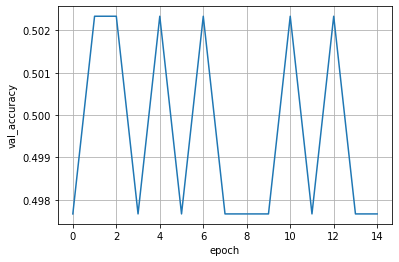

Maximum val_accuracy observed at epoch_1 is 0.5023333430290222


In [ ]:
import matplotlib.pyplot as plt
acc_list = model.history.history['val_accuracy']
plt.plot(acc_list)
plt.xlabel('epoch')  #Note: Epoch here starts from 0 simliar to tensorboard graph
plt.ylabel('val_accuracy')
plt.grid()
plt.show()

max_epoch = np.argmax(acc_list)
max_accuracy = acc_list[max_epoch]
print('Maximum val_accuracy observed at epoch_{} is {}'.format(max_epoch,max_accuracy) )

#### Model-2

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
activ = 'relu'
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)

nb_epochs = 15
batch_size = 32
model = create_model(activ,initializer,opt)
# model.summary()

In [ ]:
log_dir="logs/fit/model2_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)
callbacks_list = [tensorboard_callback]

model.fit(X_train,y_train, batch_size = batch_size ,epochs = nb_epochs, verbose =0,
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

In [ ]:
%tensorboard --logdir logs/fit

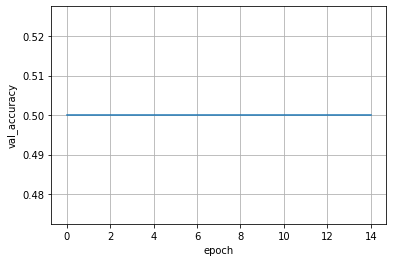

Maximum val_accuracy observed at epoch_0 is 0.5


In [ ]:
import matplotlib.pyplot as plt
acc_list = model.history.history['val_accuracy']
plt.plot(acc_list)
plt.xlabel('epoch')  #Note: Epoch here starts from 0 simliar to tensorboard graph
plt.ylabel('val_accuracy')
plt.grid()
plt.show()

max_epoch = np.argmax(acc_list)
max_accuracy = acc_list[max_epoch]
print('Maximum val_accuracy observed at epoch_{} is {}'.format(max_epoch,max_accuracy) )

#### Model-3

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
activ = 'relu'
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
initializer = 'he_uniform'

nb_epochs = 15
batch_size = 32
model = create_model(activ,initializer,opt)
# model.summary()

In [ ]:
log_dir="logs/fit/model3_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)
callbacks_list = [tensorboard_callback]

model.fit(X_train,y_train, batch_size = batch_size ,epochs = nb_epochs, verbose =0,
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

In [ ]:
%tensorboard --logdir logs/fit

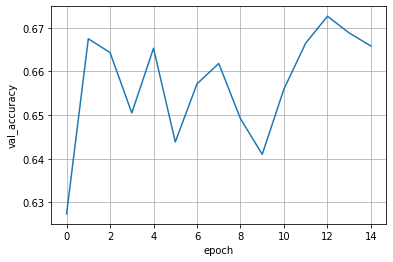

Maximum val_accuracy observed at epoch_12 is 0.6726666688919067


In [ ]:
import matplotlib.pyplot as plt
acc_list = model.history.history['val_accuracy']
plt.plot(acc_list)
plt.xlabel('epoch')  #Note: Epoch here starts from 0 simliar to tensorboard graph
plt.ylabel('val_accuracy')
plt.grid()
plt.show()

max_epoch = np.argmax(acc_list)
max_accuracy = acc_list[max_epoch]
print('Maximum val_accuracy observed at epoch_{} is {}'.format(max_epoch,max_accuracy) )

#### Model-4

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
activ = 'relu'
opt = 'adam'
initializer = 'he_normal'

nb_epochs = 15
batch_size = 32
model = create_model(activ,initializer,opt)
# model.summary()

In [ ]:
log_dir="logs/fit/model4_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq=1, write_graph = True)
callbacks_list = [tensorboard_callback]

model.fit(X_train,y_train, batch_size = batch_size ,epochs = nb_epochs, verbose =0,
                    validation_data = (X_test,y_test), callbacks= callbacks_list )

In [ ]:
# !kill 2914

In [ ]:
%tensorboard --logdir logs/fit

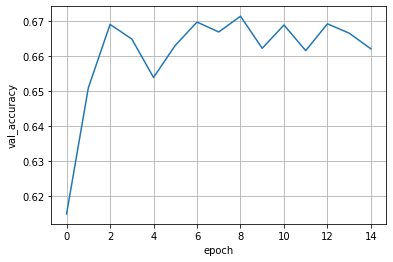

Maximum val_accuracy observed at epoch_8 is 0.6713333129882812


In [ ]:
import matplotlib.pyplot as plt
acc_list = model.history.history['val_accuracy']
plt.plot(acc_list)
plt.xlabel('epoch')  #Note: Epoch here starts from 0 simliar to tensorboard graph
plt.ylabel('val_accuracy')
plt.grid()
plt.show()

max_epoch = np.argmax(acc_list)
max_accuracy = acc_list[max_epoch]
print('Maximum val_accuracy observed at epoch_{} is {}'.format(max_epoch,max_accuracy) )